In [32]:
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, Dropout, Dense
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from python_speech_features import mfcc

In [53]:
def build_mfcc(config, df, path='clean/'):
    'builds 64 mfcc features (64x9)'
    c = config
    X = []
    y = []
    _min, _max = float('inf'), float('-inf')
    for f in tqdm(df.index):
        rate, wav = wavfile.read(path+f)
        wav = wav.sum(axis=1)
        wav = wav.astype(float)
        label = df.at[f, 'label']
        step = c.step
        for i in range(0, len(wav), step):
            partition = i+step
            if step > wav.shape[0]:
                signal = np.zeros((step, 1))
                signal[:wav.shape[0], :] = wav.reshape(-1, 1)
                X_mfcc = mfcc(signal, rate,
                                   numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            elif partition > len(wav):
                X_mfcc = mfcc(wav[-step:], rate,
                                   numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            else:
                X_mfcc = mfcc(wav[i:i+step], rate,
                                   numcep=c.nfeat, nfilt=c.nfeat, nfft=c.nfft).T
            _min = min(np.amin(X_mfcc), _min)
            _max = max(np.amax(X_mfcc), _max)
            X.append(X_mfcc)
            y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    print(_min, _max)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    y = to_categorical(y, num_classes=2)
    return X, y

In [34]:
def build_1d(config):
    'builds 1d data simply to show 1d convolutions are possible'
    c = config
    X = []
    y = []
    for f in df.index:
        rate, wav = wavfile.read('clean/'+f)
        label = df.at[f, 'label']
        step = c.step
        for i in range(0, len(wav), step):
            partition = i+step
            if step > wav.shape[0]:
                signal = np.zeros((step, 1))
                signal[:wav.shape[0], :] = wav
            elif partition > len(wav):
                signal = wav[-step:]
            else:
                signal = wav[i:i+step]
            X.append(signal)
            y.append(classes.index(label))
    X, y = np.array(X), np.array(y)
    mms = MinMaxScaler()
    X = mms.fit_transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = to_categorical(y, num_classes=10)
    return X, y

In [35]:
def get_1d_model():
    model = Sequential()
    model.add(Conv1D(16, 9, activation='relu', padding='same',
                     input_shape=input_shape))
    model.add(Conv1D(16, 9, activation='relu', padding='same'))
    model.add(MaxPool1D(16))
    model.add(Dropout(rate=0.1))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(MaxPool1D(4))
    model.add(Dropout(rate=0.1))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPool1D(4))
    model.add(Dropout(rate=0.1))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [45]:
def get_2d_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', strides=(2, 2),
                     padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [37]:
class Config:
    def __init__(self, mode='two', nfeat=64, nfft=1103, rate=44100):
        self.mode = mode
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)

In [38]:
df = pd.read_csv('sounds.csv', header=None)
df.rename(columns={0: "fname", 1: "label"}, inplace=True)
df.set_index('fname', inplace=True)

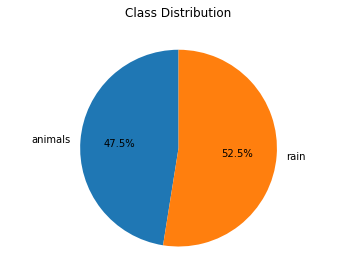

In [39]:
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    signal = signal.sum(axis=1)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [40]:
config = Config(mode='two', nfeat=64, nfft=1103, rate=44100)

In [54]:
if config.mode == 'one':
    X, y = build_1d(config)
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], 1)
    model = get_1d_model()
    
elif config.mode == 'two':
    X, y = build_mfcc(config, df)
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_2d_model()

100%|██████████| 242/242 [00:51<00:00,  4.63it/s]


-193.80485258273006 134.46716346352255
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 5, 16)         416       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 5, 32)         4640      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 5, 64)         18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 2, 64)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 2, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6

In [42]:
print(input_shape)

(64, 9, 1)


In [43]:
class_weight = compute_class_weight('balanced',
                                     np.unique(y_flat),
                                     y_flat)

In [47]:
model.fit(X, y, epochs=2, batch_size=32,
          shuffle=True,
          class_weight=class_weight)

W0804 12:13:54.442294  3412 deprecation.py:323] From D:\Games\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2


16256/23070 [====================>.........] - ETA: 5:40 - loss: 0.6934 - acc: 0.531 - ETA: 1:37 - loss: 0.6966 - acc: 0.453 - ETA: 1:02 - loss: 0.6955 - acc: 0.477 - ETA: 48s - loss: 0.6948 - acc: 0.493 - ETA: 40s - loss: 0.6935 - acc: 0.51 - ETA: 37s - loss: 0.6928 - acc: 0.52 - ETA: 33s - loss: 0.6925 - acc: 0.51 - ETA: 31s - loss: 0.6906 - acc: 0.53 - ETA: 29s - loss: 0.6894 - acc: 0.53 - ETA: 28s - loss: 0.6884 - acc: 0.53 - ETA: 28s - loss: 0.6878 - acc: 0.53 - ETA: 27s - loss: 0.6871 - acc: 0.53 - ETA: 26s - loss: 0.6851 - acc: 0.53 - ETA: 26s - loss: 0.6836 - acc: 0.53 - ETA: 25s - loss: 0.6815 - acc: 0.54 - ETA: 25s - loss: 0.6780 - acc: 0.55 - ETA: 24s - loss: 0.6690 - acc: 0.57 - ETA: 23s - loss: 0.6614 - acc: 0.59 - ETA: 23s - loss: 0.6592 - acc: 0.59 - ETA: 23s - loss: 0.6498 - acc: 0.60 - ETA: 23s - loss: 0.6501 - acc: 0.60 - ETA: 22s - loss: 0.6365 - acc: 0.61 - ETA: 22s - loss: 0.6293 - acc: 0.62 - ETA: 22s - loss: 0.6197 - acc: 0.63 - ETA: 22s - loss: 0.6152 - acc: 0.6

23070/23070 [==============================] - ETA: 5s - loss: 0.1318 - acc: 0.939 - ETA: 5s - loss: 0.1313 - acc: 0.939 - ETA: 5s - loss: 0.1305 - acc: 0.939 - ETA: 5s - loss: 0.1298 - acc: 0.940 - ETA: 5s - loss: 0.1296 - acc: 0.940 - ETA: 5s - loss: 0.1289 - acc: 0.940 - ETA: 5s - loss: 0.1285 - acc: 0.940 - ETA: 4s - loss: 0.1279 - acc: 0.941 - ETA: 4s - loss: 0.1273 - acc: 0.941 - ETA: 4s - loss: 0.1273 - acc: 0.941 - ETA: 4s - loss: 0.1268 - acc: 0.941 - ETA: 4s - loss: 0.1265 - acc: 0.942 - ETA: 4s - loss: 0.1259 - acc: 0.942 - ETA: 4s - loss: 0.1256 - acc: 0.942 - ETA: 4s - loss: 0.1254 - acc: 0.942 - ETA: 4s - loss: 0.1248 - acc: 0.942 - ETA: 4s - loss: 0.1243 - acc: 0.943 - ETA: 4s - loss: 0.1237 - acc: 0.943 - ETA: 4s - loss: 0.1237 - acc: 0.943 - ETA: 4s - loss: 0.1233 - acc: 0.943 - ETA: 3s - loss: 0.1229 - acc: 0.944 - ETA: 3s - loss: 0.1226 - acc: 0.944 - ETA: 3s - loss: 0.1224 - acc: 0.944 - ETA: 3s - loss: 0.1224 - acc: 0.944 - ETA: 3s - loss: 0.1221 - acc: 0.944 - ETA

15712/23070 [===================>..........] - ETA: 18s - loss: 0.0750 - acc: 0.96 - ETA: 18s - loss: 0.0649 - acc: 0.97 - ETA: 17s - loss: 0.0336 - acc: 0.98 - ETA: 18s - loss: 0.0257 - acc: 0.99 - ETA: 18s - loss: 0.0214 - acc: 0.99 - ETA: 18s - loss: 0.0301 - acc: 0.99 - ETA: 18s - loss: 0.0265 - acc: 0.99 - ETA: 18s - loss: 0.0242 - acc: 0.99 - ETA: 17s - loss: 0.0216 - acc: 0.99 - ETA: 17s - loss: 0.0253 - acc: 0.99 - ETA: 17s - loss: 0.0234 - acc: 0.99 - ETA: 17s - loss: 0.0262 - acc: 0.99 - ETA: 17s - loss: 0.0252 - acc: 0.99 - ETA: 17s - loss: 0.0269 - acc: 0.99 - ETA: 17s - loss: 0.0286 - acc: 0.99 - ETA: 17s - loss: 0.0338 - acc: 0.99 - ETA: 17s - loss: 0.0318 - acc: 0.99 - ETA: 17s - loss: 0.0306 - acc: 0.99 - ETA: 17s - loss: 0.0328 - acc: 0.99 - ETA: 17s - loss: 0.0314 - acc: 0.99 - ETA: 17s - loss: 0.0303 - acc: 0.99 - ETA: 17s - loss: 0.0292 - acc: 0.99 - ETA: 17s - loss: 0.0308 - acc: 0.99 - ETA: 17s - loss: 0.0299 - acc: 0.99 - ETA: 17s - loss: 0.0285 - acc: 0.99 - ETA

23070/23070 [==============================] - ETA: 5s - loss: 0.0157 - acc: 0.996 - ETA: 5s - loss: 0.0157 - acc: 0.996 - ETA: 5s - loss: 0.0157 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0155 - acc: 0.996 - ETA: 5s - loss: 0.0155 - acc: 0.996 - ETA: 5s - loss: 0.0155 - acc: 0.996 - ETA: 5s - loss: 0.0155 - acc: 0.996 - ETA: 4s - loss: 0.0154 - acc: 0.996 - ETA: 4s - loss: 0.0153 - acc: 0.996 - ETA: 4s - loss: 0.0152 - acc: 0.996 - ETA: 4s - loss: 0.0152 - acc: 0.996 - ETA: 4s - loss: 0.0151 - acc: 0.996 - ETA: 4s - loss: 0.0150 - acc: 0.996 - ETA: 4s - loss: 0.0150 - acc: 0.996 - ETA: 4s - loss: 0.0149 - acc: 0.996 - ETA: 4s - loss: 0.0148 - acc: 0.996 - ETA: 4s - loss: 0.0148 - acc: 0.996 - ETA: 4s - loss: 0.0147 - acc: 0.996 - ETA: 4s - loss: 0.0147 - acc: 0.996 - ETA: 4s - loss: 0.0146 - acc: 0.996 - ETA

In [52]:
model_yaml = model.to_yaml()
with open('mfcc.yaml', 'w') as yaml_file:
    yaml_file.write(model_yaml)
model.save_weights('mfcc.h5')

In [51]:
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [52]:
model.predict(X)

array([[3.7401915e-05, 2.6598203e-01],
       [3.3646822e-05, 2.4973902e-01],
       [1.7374754e-05, 3.7783152e-01],
       ...,
       [9.9976891e-01, 0.0000000e+00],
       [9.9533075e-01, 0.0000000e+00],
       [9.9991906e-01, 0.0000000e+00]], dtype=float32)